# Queen Bee Detection System

This notebook demonstrates the audio processing and machine learning pipeline for detecting queen bee presence in hive audio recordings.

In [10]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
import seaborn as sns
import joblib

## 1. Data Loading and Exploration

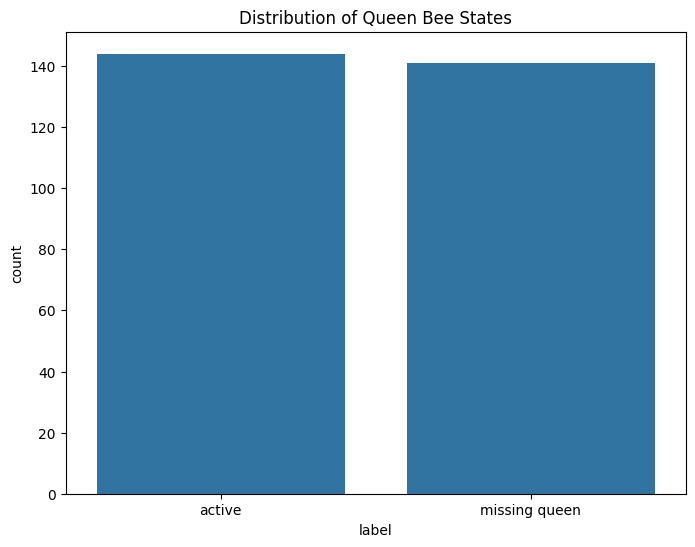

Label distribution:
label
active           144
missing queen    141
Name: count, dtype: int64


In [3]:
# Load labels
data_dir = "../../dataset"
labels_file = os.path.join(data_dir, 'state_labels.csv')
labels_df = pd.read_csv(labels_file)

# Display label distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=labels_df, x='label')
plt.title('Distribution of Queen Bee States')
plt.show()

print("Label distribution:")
print(labels_df['label'].value_counts())

## 2. Feature Extraction Functions

In [13]:
def extract_features(audio_path):
    """Extract audio features using librosa"""
    try:
        y, sr = librosa.load(audio_path, sr=None)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y)
        features = []
        for feature in [mfccs, spectral_centroid, spectral_bandwidth, spectral_rolloff, zero_crossing_rate]:
            features.extend([
                np.mean(feature),
                np.std(feature),
                np.min(feature),
                np.max(feature)
            ])
        mel_features = []
        for i in range(mel_spec_db.shape[0]):
            mel_features.extend([
                np.mean(mel_spec_db[i]),
                np.std(mel_spec_db[i])
            ])
        features.extend(mel_features)
        return np.array(features), y, sr, mfccs, mel_spec_db
    except Exception as e:
        print(f"Error processing {audio_path}: {str(e)}")
        return None, None, None, None, None

## 3. Visualize Audio Features

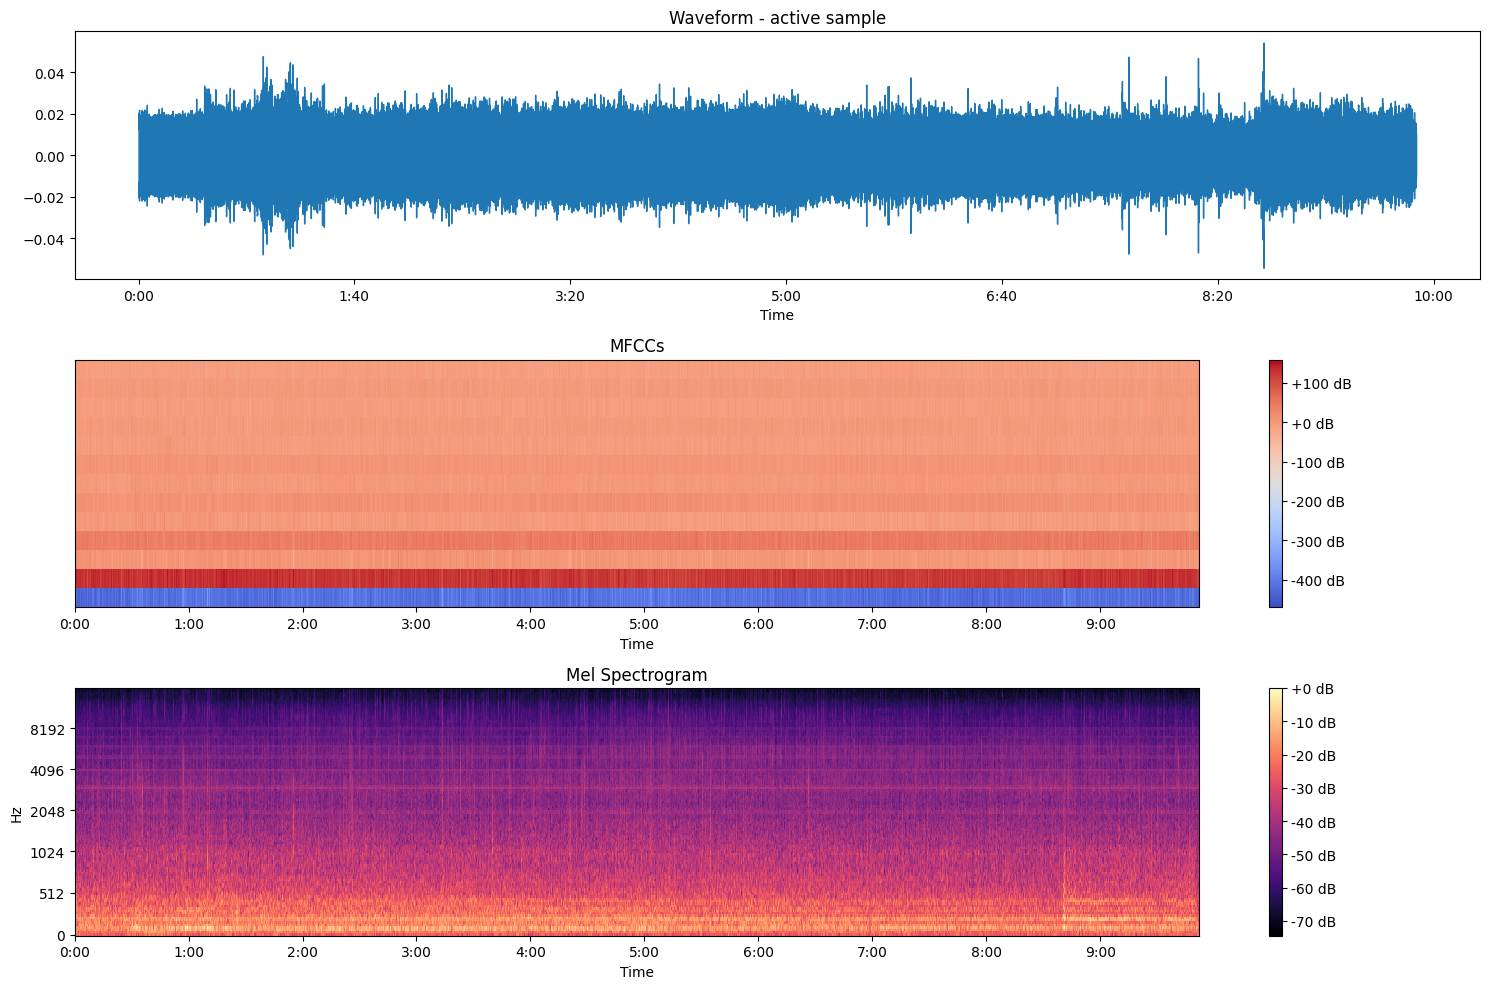

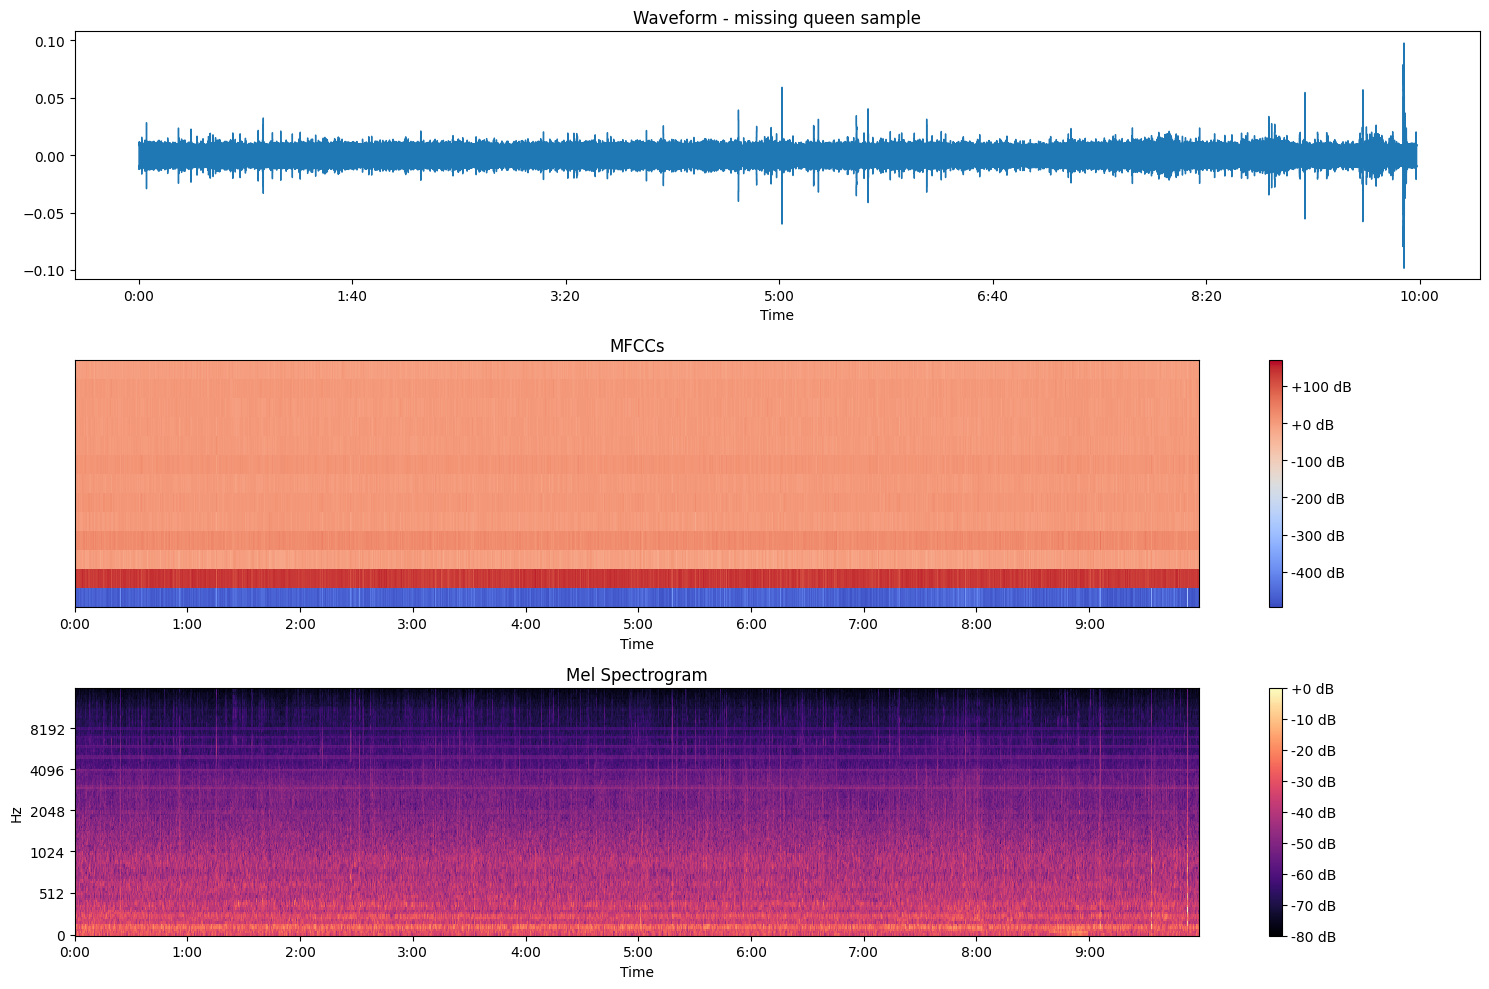

In [5]:
def plot_audio_features(y, sr, mfccs, mel_spec_db, title):
    plt.figure(figsize=(15, 10))
    plt.subplot(3, 1, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title(f'Waveform - {title}')
    plt.subplot(3, 1, 2)
    librosa.display.specshow(mfccs, sr=sr, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('MFCCs')
    plt.subplot(3, 1, 3)
    librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.tight_layout()
    plt.show()

for label in ['active', 'missing queen']:
    sample = labels_df[labels_df['label'] == label].iloc[0]
    sample_name = sample['sample_name']
    audio_dir = os.path.join(data_dir, 'NoQueen Bee') if 'NO_QueenBee' in sample_name else os.path.join(data_dir, 'Queen Bee')
    audio_file = next((os.path.join(audio_dir, file) for file in os.listdir(audio_dir) if sample_name in file), None)
    if audio_file:
        features, y, sr, mfccs, mel_spec_db = extract_features(audio_file)
        if features is not None:
            plot_audio_features(y, sr, mfccs, mel_spec_db, f"{label} sample")

## 4. Prepare Dataset

In [6]:
def prepare_dataset(data_dir, labels_file):
    labels_df = pd.read_csv(labels_file)
    features = []
    labels = []
    for _, row in labels_df.iterrows():
        sample_name = row['sample_name']
        label = row['label']
        audio_dir = os.path.join(data_dir, 'NoQueen Bee') if 'NO_QueenBee' in sample_name else os.path.join(data_dir, 'Queen Bee')
        audio_file = next((os.path.join(audio_dir, file) for file in os.listdir(audio_dir) if sample_name in file), None)
        if audio_file:
            feature_vector, _, _, _, _ = extract_features(audio_file)
            if feature_vector is not None:
                features.append(feature_vector)
                labels.append(1 if label == 'active' else 0)
    return np.array(features), np.array(labels)

X, y = prepare_dataset(data_dir, labels_file)
print(f"Feature matrix shape: {X.shape}")
print(f"Number of samples: {len(y)}")

Feature matrix shape: (285, 276)
Number of samples: 285


In [7]:
# df = pd.DataFrame(X)
# df['label'] = y
# df.to_csv('queenbee_dataset.csv', index=False)

df_loaded = pd.read_csv('../../dataset/queenbee_dataset.csv')
X_loaded = df_loaded.iloc[:, :-1].values
y_loaded = df_loaded['label'].values

## 5. Train Model

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_loaded, y_loaded, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)
accuracy = model.score(X_test_scaled, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

y_pred = model.predict(X_test_scaled)
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")

Test Accuracy: 0.9123
F1 Score: 0.9091


In [13]:
joblib.dump(model, '../model/queenbee_rf_model.pkl')
joblib.dump(scaler, '../model/scaler.pkl')

['../model/scaler.pkl']

In [18]:
model = joblib.load('../model/queenbee_rf_model.pkl')
scaler = joblib.load('../model/scaler.pkl')

def predict_audio(file_path):
    feature_vector, _, _, _, _ = extract_features(file_path)
    if feature_vector is not None:
        feature_vector_scaled = scaler.transform([feature_vector])
        prediction = model.predict(feature_vector_scaled)[0]
        prob = model.predict_proba(feature_vector_scaled)[0].max()
        label = "Queen Bee is Present" if prediction == 1 else "Queen Bee is Absent"
        print(f"Prediction: {label} (Confidence: {prob:.2f})")
    else:
        print("Could not extract features from audio.")

# 🔍 Replace this with your test file path
predict_audio("../../dataset/Queen Bee/Hive1 12_06_2018_QueenBee____00_40_00.wav")


Prediction: Queen Bee is Present (Confidence: 1.00)
